Semantic JsonSchema types in python.

In [1]:
    import jsonschema, requests, requests_cache, json, gc
    import dataclasses, typing, pandas, toolz.curried as toolz, anyconfig, fastjsonschema
    #requests_cache.install_cache('schemas.sqlite')
    import jsonschema, nbformat, collections, hypothesis_jsonschema, importlib, sys

In [2]:
    class Garbage:
        def num_refs(x): return gc.collect() and sys.getrefcount(x)
        def referrers(x): return gc.collect() and gc.get_referrers(x)
        def referents(x): return gc.collect() and gc.get_referents(x)
        def find(self, ns='__main__'):
            hash = id(self)
            return {k for k, v in vars(importlib.import_module(ns) if isinstance(ns, str) else ns).items() if id(v) == hash}
        
        def type(self): return type(self)

In [3]:
    class JsonSchemaType(__import__('abc').ABCMeta, Garbage):
        __meta_schema__ = jsonschema.Draft7Validator.META_SCHEMA
        def __new__(cls, name, base, kwargs, **schema):
            """Create a new JsonSchemaType type.  Validate the schema on the metaschema. x"""
            self = super().__new__(cls, name, base, kwargs)
            self.__schema__ = dict(collections.ChainMap(schema, *(getattr(cls, '__schema__', {}) for cls in self.__mro__)))
            self.validate_meta_schema(self.__schema__)
            return self
        
        @classmethod
        def validate_meta_schema(cls, object): jsonschema.validate(object, cls.__meta_schema__, format_checker=jsonschema.draft7_format_checker)
        
        @classmethod
        def validate(cls, object): assert isinstance(object, cls)
        
        def __instancecheck__(cls, object):
            try: return jsonschema.validate(object, cls.__schema__, format_checker=jsonschema.draft7_format_checker) or True
            except: return False
                
        def discover(x, object=None, **schema):
            for cls in x.__subclasses__():
                try: return cls.discover(cls(getattr(object, 'object', object)))
                except BaseException as e: ...
            return object
        
        def new(cls, **schema):  
            schema = {**cls.__schema__, **(object if isinstance(object, dict) else {}), **schema}
            return type(schema.get('title', __import__('json').dumps(schema)), (cls,), {}, **schema)
        
        def example(cls):  return hypothesis_jsonschema.from_schema(cls.__schema__).example()

In [4]:
    class JsonSchema(Garbage, metaclass=JsonSchemaType):
        __context__ = F"{jsonschema.Draft7Validator.META_SCHEMA['$schema']}/properties/"
        def __new__(cls, *args, **kwargs):
            if args: assert isinstance(args[0], cls)
            return super().__new__(cls, *args, **kwargs); self.__init__(*args, **kwargs)
        
        def __repr__(x): return x.dumps()
        def dumps(x, *args, **kwargs):
            return __import__('ujson').dumps(x, *args, **kwargs)
    discover = JsonSchema.discover

In [5]:
    class Null(JsonSchema, type='null'): 
        def __new__(cls, object=None, *args, **kwargs): return cls.__schema__.validate(object)
    class Integer(JsonSchema, int, type='integer'): ...
    class Number(JsonSchema, float, type='number'): ...
    class List(JsonSchema, list, type='array'): 
        def __new__(cls, *args, **kwargs): 
            if isinstance(args[0], tuple): args = (list(args[0]),) + args[1:]
            return super().__new__(cls, *args, **kwargs)        
    class Dict(JsonSchema, dict, type='object'): 
        def __new__(cls, *args, **kwargs): 
            args, kwargs = ({**(args and args[0] or {}), **kwargs},), {}
            return super().__new__(cls, *args, **kwargs)        

        def __init_subclass__(cls, **schema): 
            cls.__schema__.update(schema)
            if getattr(cls, '__annotations__', {}):
                cls.__schema__.update(properties={key: value.__schema__ for key, value in getattr(cls, '__annotations__', {}).items() if hasattr(value, '__schema__')})
            cls.validate_meta_schema(cls.__schema__)            
            
    class String(JsonSchema, str, type='string'): 
        def parse(x, *args, **kwargs): return discover(anyconfig.loads(x, *args, **kwargs))
        def json(x): return __import__('ujson').loads(x)

In [6]:
    class Object(JsonSchema):
        """Use abc registration to connect to python types."""
        __context__ = None
        object: None        
        def __new__(cls, *args, **kwargs):  self = object.__new__(cls); self.__init__(*args, **kwargs); return self
        def __post_init__(x): x.object = getattr(x, 'object', x.object); assert isinstance(x.object, type(x))
        def _repr_mimebundle_(x, include=None, exclude=None, **metadata): return {}, metadata
    
    dataclasses.dataclass(Object)        

__main__.Object

[NbConvertApp] Converting notebook schemas.ipynb to script
[NbConvertApp] Writing 4920 bytes to schemas.py
reformatted schemas.py
All done! ✨ 🍰 ✨
1 file reformatted.
parsing /Users/tonyfast/xxxxx/tonyfast/jschema/schemas.py...


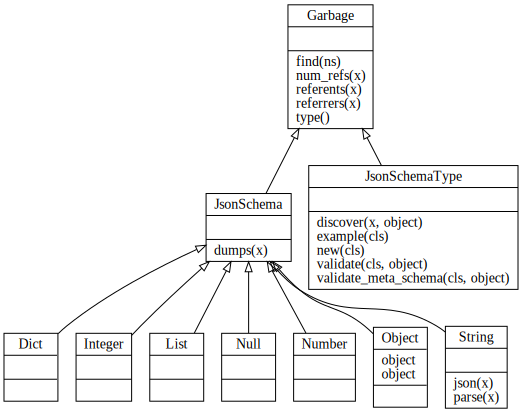

In [9]:
    if __name__ == '__main__': 
        !jupyter nbconvert --to script schemas.ipynb
        !black schemas.py
        !pyreverse schemas -osvg -pschemas
        
        display(__import__('IPython').display.SVG('classes_schemas.svg'))
        !rm schemas.py classes_schemas.svg